# Load the dataset

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

drive_root = '/content/drive/MyDrive/data'
files = os.listdir(drive_root)
print(files)

Mounted at /content/drive
['human', 'AI', '.ipynb_checkpoints']


In [ ]:
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision import transforms

# Define a custom dataset class
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import default_loader

class CustomImageFolder(VisionDataset):
    def __init__(self, root, label, transform=None, loader=default_loader):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=None)

        self.root = root
        self.label = label  # Assign the same label to all images in the folder
        self.loader = loader
        self.image_paths = self._get_image_paths()


    def _get_image_paths(self):
        image_paths = []
        for filename in sorted(os.listdir(self.root)):
            if self.loader(os.path.join(self.root, filename)):
                image_paths.append(os.path.join(self.root, filename))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = self.loader(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, self.label


# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()])

# Create an instance of your custom dataset
ai_folder = os.path.join(drive_root,files[1])
human_folder = os.path.join(drive_root,files[0])


In [ ]:
data_ai = CustomImageFolder(root=ai_folder, label=0, transform=None)
data_human = CustomImageFolder(root=human_folder, label=1, transform=None)

# Split the dataset

In [ ]:
combined_dataset = ConcatDataset([data_ai, data_human])
train_dataset, pretrain_dataset, test_dataset = random_split(combined_dataset, [0.75, 0.1, 0.15])

class TransformDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]
        transformed_img = self.transform(img)

        return transformed_img, label
train_dataset = TransformDataset(train_dataset, transform)
test_dataset = TransformDataset(test_dataset, transform)

In [ ]:
print(len(train_dataset), len(pretrain_dataset), len(test_dataset))

675 90 135


## Sample of the dataset

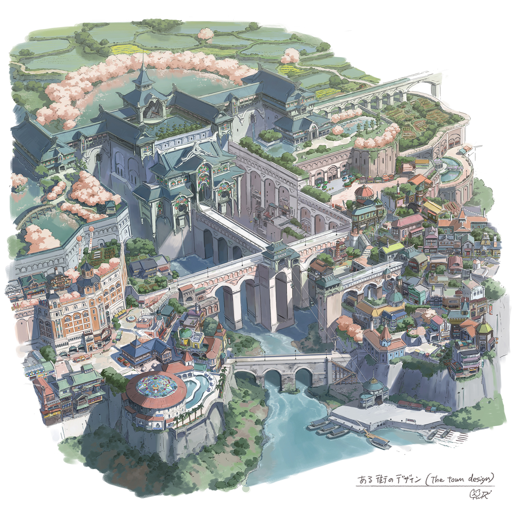

Human


In [ ]:
img,label = pretrain_dataset.__getitem__(1)
img = img.resize((512,512))

label_names = ['AI','Human']
display(img)
print(label_names[label])


# Data augmentation

In [ ]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import transforms

np.random.seed(0)

# GaussianBlur, code from sthalles/SimCLR. Github: https://github.com/sthalles/SimCLR.
class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

In [ ]:
from torchvision.transforms import transforms
from torchvision import transforms, datasets
np.random.seed(0)

size = 512
s = 1
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size, scale=(0.5, 1.0)),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomApply([color_jitter], p=0.5),
                    #transforms.RandomGrayscale(p=0.5),
                    #GaussianBlur(kernel_size=size),
                    transforms.ToTensor()])

class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform, expand_factor=2):
        self.original_dataset = original_dataset
        self.transform = transform
        self.expand_factor = expand_factor
        self.augmented_images = []

        for img, label in self.original_dataset:
            augmented_versions = []
            for _ in range(self.expand_factor):
                transformed_img = self.transform(img)
                self.augmented_images.append((transformed_img, label))

    def __len__(self):
        return len(self.original_dataset) * self.expand_factor

    def __getitem__(self, idx):
        transformed_img, label = self.augmented_images[idx]

        return transformed_img, label

auged_pretrain_dataset = AugmentedDataset(pretrain_dataset, data_transforms)

## Samples of augmented data

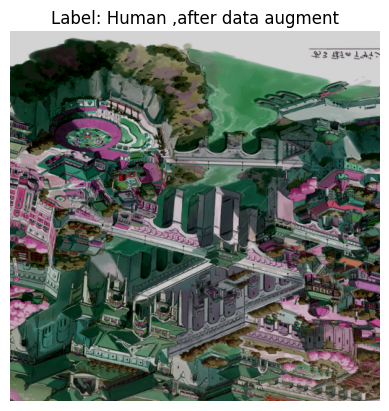

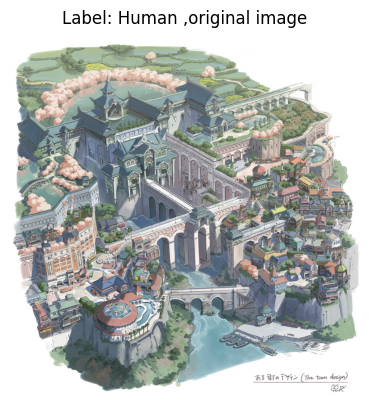

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img, label = auged_pretrain_dataset[2]
og_img, label = pretrain_dataset[1]

# Convert each image tensor to a NumPy array and prepare for display
image = img.detach().cpu().numpy()

# Ensure each image has the correct shape (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# Display the PIL Image using matplotlib
plt.imshow(image)
plt.title(f"Label: {label_names[label]} ,after data augment")  # Display label as title
plt.axis('off')  # Turn off axis labelsz
plt.show()

plt.imshow(og_img)
plt.title(f"Label: {label_names[label]} ,original image")
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
pretrain_dataloader = DataLoader(auged_pretrain_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
img,label = next(iter(pretrain_dataloader))

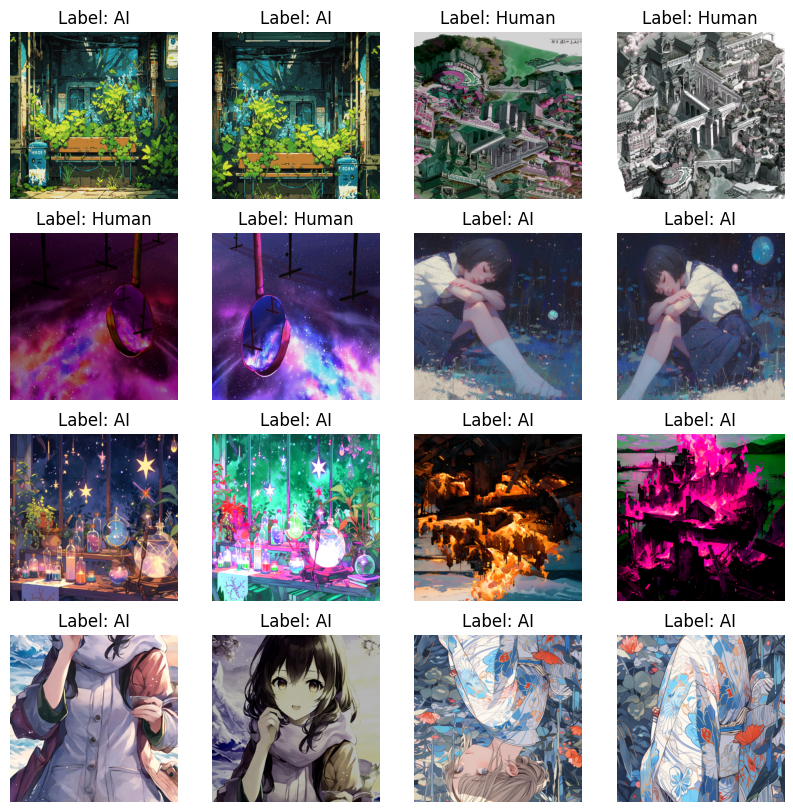

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10,10))
ind = 0
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        ax.axis("off")

        image = img[ind].detach().cpu().numpy()

# Ensure each image has the correct shape (height, width, channels)
        image = np.transpose(image, (1, 2, 0))

        ax.imshow(image)
        ax.set_title(f"Label: {label_names[label[ind]]}")
        ind+=1
plt.show()


# Self-supervised learning

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Pretext task

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = resnet50(pretrained=False)
num_features = model.fc.in_features
torch.cuda.empty_cache()
# Replace final fully connected layer for self-supervised pretraining
model.fc = nn.Linear(num_features, 128)  # Output embedding size for contrastive learning
model.to(device)  # Move model to device


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=64.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):

        pos_dist = nn.functional.pairwise_distance(anchor, positive)
        neg_dist = nn.functional.pairwise_distance(anchor, negative)

        loss = torch.mean(torch.clamp(pos_dist - neg_dist + self.margin, min=0.0))
        return loss

criterion_contrastive = ContrastiveLoss().to(device)
optimizer_contrastive = optim.Adam(model.parameters(), lr=0.00001)

num_epochs_pretrain = 0
pretrain_loss_history = []
for epoch in range(num_epochs_pretrain):
    model.train()
    for images, _ in pretrain_dataloader:
        images = images.to(device)

        # Create positive and negative pairs for contrastive learning
        anchor = images[0::4]
        positive = images[1::4]
        #positive = transforms.RandomRotation(degrees=[-180, 180])(anchor)
        negative = images[2::4]


        optimizer_contrastive.zero_grad()
        output1 = model(anchor)
        output2 = model(positive)
        output3 = model(negative)


        loss_contrastive = criterion_contrastive(output1, output2, output3)
        loss_contrastive.backward()
        optimizer_contrastive.step()

    pretrain_loss_history.append(loss_contrastive.item())
    print(f'Epoch {epoch+1}, Loss: {loss_contrastive.item()}')
    if loss_contrastive.item()<=1e-6:
      break

print("Self-supervised pretraining completed.")

Self-supervised pretraining completed.


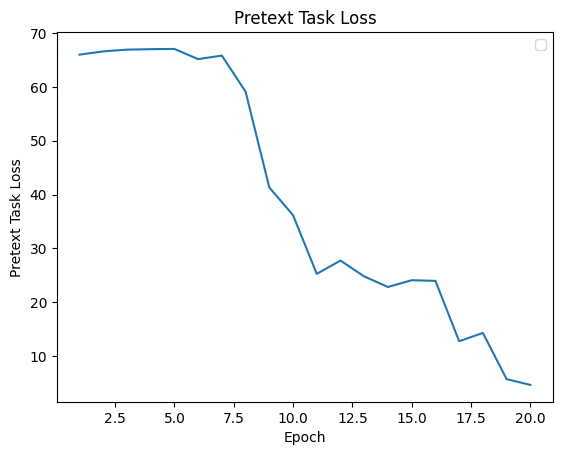

In [ ]:
plt.plot(np.arange(1, len(pretrain_loss_history)+1), pretrain_loss_history)
plt.title('Pretext Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Pretext Task Loss')
plt.legend()
plt.show()

## Samples of the anchor

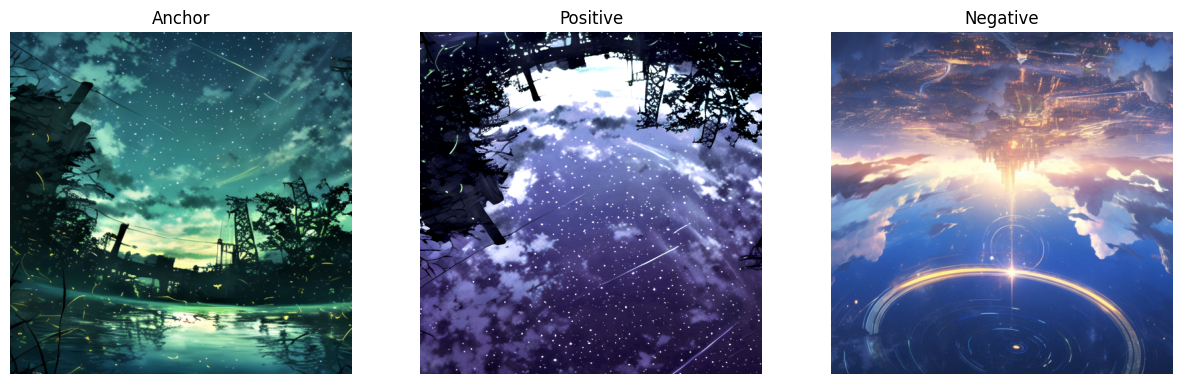

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

to_pil = transforms.ToPILImage()
anchor_img = to_pil(anchor[0])
positive_img = to_pil(positive[0])
negative_img = to_pil(negative[0])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(anchor_img)
axs[0].set_title("Anchor")
axs[0].axis('off')

axs[1].imshow(positive_img)
axs[1].set_title("Positive")
axs[1].axis('off')

axs[2].imshow(negative_img)
axs[2].set_title("Negative")
axs[2].axis('off')

plt.show()

# Fine tuning

In [ ]:
from sklearn.metrics import accuracy_score


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


criterion_classification = nn.CrossEntropyLoss().to(device)
optimizer_classification = optim.Adam(model.parameters(), lr=0.00001)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []


num_epochs_finetune = 100
for epoch in range(num_epochs_finetune):
    model.train()

    epoch_loss = 0.0
    epoch_accuracy = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer_classification.zero_grad()

        outputs = model(images)
        loss_classification = criterion_classification(outputs, labels)
        loss_classification.backward()
        optimizer_classification.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        batch_accuracy = accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())
        epoch_accuracy += batch_accuracy

        epoch_loss += loss_classification.item()

    epoch_loss /= len(train_dataloader)
    epoch_accuracy /= len(train_dataloader)
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_accuracy)

    print('epoch:{}, Train loss:{}, Train acc:{}'.format(epoch+1,train_loss_history[-1],train_acc_history[-1]))

    model.eval()

    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)

          loss = criterion_classification(outputs, labels)
          test_loss += loss.item()

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_dataloader)
    test_loss_history.append(average_loss)
    test_acc_history.append(accuracy)
    print('epoch:{}, Test loss:{}, Test acc:{}'.format(epoch+1,test_loss_history[-1],test_acc_history[-1]))


# Save the fine-tuned model
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)
print(f"Fine-tuned model saved at: {save_path}")


epoch:1, Train loss:4.3043319962241435, Train acc:0.2741477272727273
epoch:1, Test loss:4.0395807266235355, Test acc:0.4740740740740741
epoch:2, Train loss:3.2004115148024126, Train acc:0.5175189393939393
epoch:2, Test loss:3.028519535064697, Test acc:0.4740740740740741
epoch:3, Train loss:2.2422851649197666, Train acc:0.5175189393939393
epoch:3, Test loss:2.1598971366882322, Test acc:0.5037037037037037
epoch:4, Train loss:1.5140354741703381, Train acc:0.5189393939393939
epoch:4, Test loss:1.4623358726501465, Test acc:0.5111111111111111
epoch:5, Train loss:1.0757488283244045, Train acc:0.6022727272727273
epoch:5, Test loss:1.1703292608261109, Test acc:0.4962962962962963
epoch:6, Train loss:0.8769691803238608, Train acc:0.6169507575757576
epoch:6, Test loss:0.875776207447052, Test acc:0.6370370370370371
epoch:7, Train loss:0.7845267409628088, Train acc:0.6060606060606061
epoch:7, Test loss:0.7931123733520508, Test acc:0.6296296296296297
epoch:8, Train loss:0.7285867956551638, Train acc:

## Plot the result

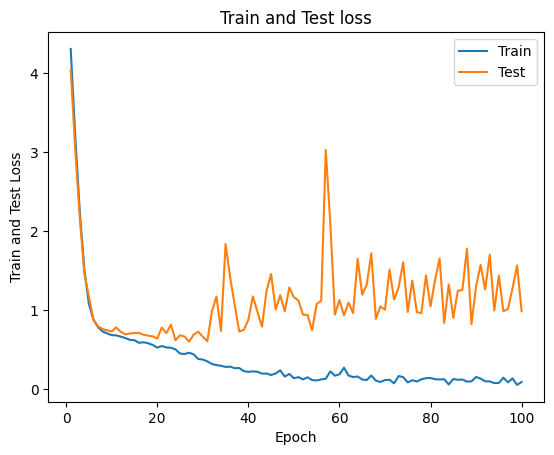

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, len(train_loss_history)+1), train_loss_history, label='Train')
plt.plot(np.arange(1, len(test_loss_history)+1), test_loss_history, label='Test')
plt.title('Train and Test loss')
plt.xlabel('Epoch')
plt.ylabel('Train and Test Loss')
plt.legend()
plt.show()

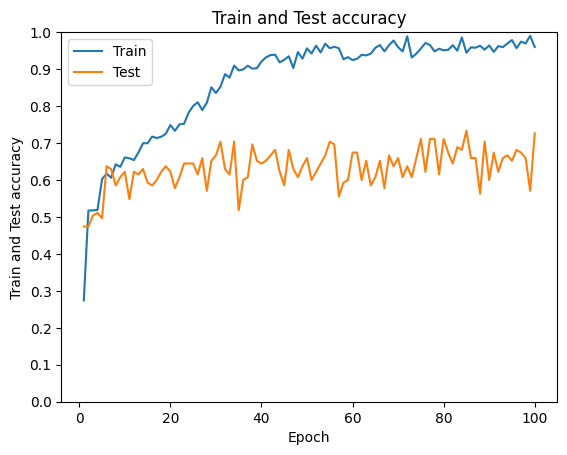

In [ ]:
plt.plot(np.arange(1, len(train_acc_history)+1), train_acc_history, label='Train')
plt.plot(np.arange(1, len(test_acc_history)+1), test_acc_history, label='Test')
plt.title('Train and Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train and Test accuracy')
plt.ylim(0, 1)
yticks = np.arange(0, 1.1, 0.1)
plt.yticks(yticks)
plt.legend()
plt.show()